$$
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\lderiv}[1]{\frac{\partial \mathcal L}{\partial #1}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\switch}[3]{\begin{cases} #2 & \text{if } {#1} \\ #3 &\text{otherwise}\end{cases}}
$$

# Introduction
In this excercise, you will get aquainted with:

0. Data preprocessing
1. Word Embeddings
2. Recurrent Neural Networks
3. Attention Mechanism
4. Character Embeddings
5. Building a closed-domain Question Answering system using all these methods


###About limits of Google Colab:   
The 12-hour limit is for a continuous assignment of VM. It means we can use GPU compute even after the end of 12 hours by connecting to a different VM.

### Author(s):
* Martin Fajčík
---
### Teaching assistant(s):
* Alžbeta Štajerová
* Jan Kočí

## Model:
Goal of this excersise is to build a model, that predicts answer span $<a_{start},a_{end}>$ given the **question** $Q$ and  a **document (alternatively referred to as 'context' or 'passage')** that contains an answer  $D$. More formally, the objective of this model is to maximize probability $P_{\theta}(a_{start},a_{end}|Q,D)$ with respect to the parameters $\theta$. The maximum likelihood estimate of our parameters $\theta$ is given as:

$$\theta ^* = \argmax{\theta} \sum_{(Q,D,a_{start},a_{end}) \in Data} log P_{\theta}(a_{start},a_{end}|Q,D)$$

We will build our model upon data from SQuAD dataset.

![Model](https://www.fit.vutbr.cz/~ifajcik/pubdata/bissit19/qaimg.png)

# Dependencies
The unusual dependencies in this excercise include:
* *torch* – automatic gradient derivation, loss optimization, pre-implemented model primitives (e.g. RNNs)
* *torchtext* – for easy processing of text data
* *spacy* – text preprocessing
* *matplotlib* – graph visualisation
* *torchviz* – torch computational graph visualisation

Some of these does not come pre-installed in the VM, and we need to install them manually.

In [ ]:
!python -m pip install torchtext==0.4.0
!pip install torchviz

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x55bff36f0000 @  0x7f471739d615 0x55bff07d94cc 0x55bff08b947a 0x55bff07dc2ed 0x55bff08cde1d 0x55bff084fe99 0x55bff084a9ee 0x55bff07ddbda 0x55bff084fd00 0x55bff084a9ee 0x55bff07ddbda 0x55bff084c737 0x55bff08cec66 0x55bff084bdaf 0x55bff08cec66 0x55bff084bdaf 0x55bff08cec66 0x55bff084bdaf 0x55bff07de039 0x55bff0821409 0x55bff07dcc52 0x55bff084fc25 0x55bff084a9ee 0x55bff07ddbda 0x55bff084c737 0x55bff084a9ee 0x55bff07ddbda 0x55bff084b915 0x55bff07ddafa 0x55bff084bc0d 0x55bff084a9ee
     |████████████████████████████████| 881.9 MB 19 kB/s 


In [ ]:
import torch
import torchtext.data as data
import string
import os
import sys
import time
import shutil
import json
import spacy
import logging
import numpy as np
import torchtext
import csv
import pandas as pd
import torch.nn as nn
import math
import torch.nn.functional as F
import socket
import copy
import datetime
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from typing import List, Tuple, Dict
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torchtext.data import BucketIterator, Iterator, RawField, Example
from urllib import request
from spacy.tokenizer import Tokenizer
from torchtext.vocab import GloVe
from torch.optim import Adam
from torchviz import make_dot
from collections import defaultdict


# Remove cached data like this if needed
# !rm -r *

# Remove pre-cached sample data in colab's directory
if os.path.isdir("sample_data"):
  shutil.rmtree("sample_data")

def get_timestamp():
    return datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')

This excercise does not include the official evaluation script from SQuAD dataset. We need to download the evaluation script manually.

In [ ]:
!wget https://www.fit.vutbr.cz/~ifajcik/pubdata/bissit19/evaluate_squad
!mv evaluate_squad evaluate_squad.py
from evaluate_squad import evaluate


--2021-11-29 20:38:30--  https://www.fit.vutbr.cz/~ifajcik/pubdata/bissit19/evaluate_squad
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3440 (3.4K) [text/plain]
Saving to: ‘evaluate_squad’

evaluate_squad      100%[===================>]   3.36K  --.-KB/s    in 0s      

2021-11-29 20:38:31 (444 MB/s) - ‘evaluate_squad’ saved [3440/3440]



Check library versions and GPU,  to follow the rest of this excersise, you should see something like this:

>Current working directory: /content  
>python version: 3.6.8 (default, Jan 14 2019, 11:02:34)   
>[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]  
>torch version: 1.1.0  
>torchtext version: 0.4.0  
>spacy version: 2.1.4   
> ... and some GPU details  





In [ ]:
print("Current working directory: " + os.getcwd())
print(f"python version: {sys.version}")
print(f"torch version: {torch.__version__}")
print(f"torchtext version: {torchtext.__version__}")
print(f"spacy version: {spacy.__version__}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    !nvidia-smi


Current working directory: /content
python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
torch version: 1.10.0+cu102
torchtext version: 0.4.0
spacy version: 2.2.4
Tesla K80
Mon Nov 29 20:38:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |   

# Dataset preparation
In this section, we will introspect, download and prepare the SQuAD dataset. 


### Looking at the data
Firstly lets take a look at few examples from the dataset. Take your time before going further and explore the data. When building a machine learning system, you should always first get aquainted with the data as much as possible.  After closely inspecting data, you may find easier to understand when and why the system does not work and use this knowledge when designing the model. Introducing the changes ot the model based on the problem understaing is often in machine learning literature referred to as *injection the inductive bias into the model*. You can find the webpage with tool to explore the dataset [here](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/).

### Handling data in torchtext
In this section, we will create code that:

*  Downloads the data.
*  Does data tokenization
* Does character-level span to token-level span mapping  – we will seek the answer by selecting the appropriate token span, but the dataset only provides character span annotation. For instance, for sentence "*The fox jumps*" with answer "*fox jumps*", the annotated character answer span will be 4-12 (character indices of answer "*fox jumps*"). Now we would like to tokenize the sentence e.g. as "*The|fox|jumps*"  and get token-level answer span 1-2.

* Prepares torchtext '*fields*' for each aspect of an example in the data – each field represents aspect of data, such as question, document, answer span etc. The further processing of each aspect of example is determined according to its respective field configuration.

## Downloading the dataset

In [ ]:
# This code snippet will download dataset for us

TRAIN_V1_URL = 'https://github.com/rajpurkar/SQuAD-explorer/raw/master/dataset/train-v1.1.json  '
DEV_V1_URL = 'https://github.com/rajpurkar/SQuAD-explorer/raw/master/dataset/dev-v1.1.json'
TRAIN = "train-v1.1.json"
VALIDATION = "dev-v1.1.json"

def download_url(path, url):
    sys.stderr.write(f'Downloading from {url} into {path}\n')
    sys.stderr.flush()
    request.urlretrieve(url, path)

##Utilities

The following method will be used to find the location of  token subsequences.

In [ ]:
def find_sub_list(sl, l):
    """
    Methods finds sublist in list and returns its indices.
    The indices are inclusive
    
    Example:
    print(find_sub_list([3,2,1],[4,3,2,1,0]))
    
    Returns:
    [(1, 3)]
    
    """
    results = []
    sll = len(sl)
    for ind in (i for i, e in enumerate(l) if e == sl[0]):
        if l[ind:ind + sll] == sl:
            results.append((ind, ind + sll - 1))

    return results

print(find_sub_list([3,2,1],[4,3,2,1,0]))

[(1, 3)]


##Tokenization
Now we would like to create a tokenizer. Tokenization is a process of splitting text into units represented at model's input.  For tokenization, we will use spacy library (see api docs [here](https://spacy.io/api)) with few handcrafted rules, e.g. to split sequences like "1980s" into "1980", "s".

In [ ]:
def create_custom_tokenizer(nlp):
    custom_prefixes = [r'[0-9]+', r'\~', r'\–', r'\—', r'\$']
    custom_infixes = [r'[!&:,()]', r'\.', r'\-', r'\–', r'\—', r'\$']
    custom_suffixes = [r'\.', r'\–', r'\—', r'\$']
    default_prefixes = list(nlp.Defaults.prefixes) + custom_prefixes
    default_prefixes.remove(r'US\$')
    default_prefixes.remove(r'C\$')
    default_prefixes.remove(r'A\$')
    
    all_prefixes_re = spacy.util.compile_prefix_regex(tuple(default_prefixes))
    infix_re = spacy.util.compile_infix_regex(tuple(list(nlp.Defaults.infixes) + custom_infixes))
    suffix_re = spacy.util.compile_suffix_regex(tuple(list(nlp.Defaults.suffixes) + custom_suffixes))

    rules = dict(nlp.Defaults.tokenizer_exceptions)
    # remove "a." to "z." rules so "a." gets tokenized as a|.
    for c in range(ord("a"), ord("z") + 1):
        if f"{chr(c)}." in rules:
            rules.pop(f"{chr(c)}.")

    return Tokenizer(nlp.vocab, rules,
                     prefix_search=all_prefixes_re.search,
                     infix_finditer=infix_re.finditer, suffix_search=suffix_re.search,
                     token_match=None)

In [ ]:
# We will use this special token to join the pre-tokenized data
JOIN_TOKEN = "█"

_spacy_en = spacy.load('en')
_spacy_en.tokenizer = create_custom_tokenizer(_spacy_en)

def tokenize(text: string, tokenizer=_spacy_en):
    tokens = [tok for tok in _spacy_en.tokenizer(text) if not tok.text.isspace()]
    text_tokens = [tok.text for tok in tokens]
    return tokens, text_tokens


def tokenize_and_join(text: string, jointoken=JOIN_TOKEN):
    return jointoken.join(tokenize(text)[1])


In [ ]:
print(tokenize_and_join("Lazy fox doesn't like to travel too far in this heat..."))
print(tokenize_and_join("Natural language processing (NLP) is a subfield of computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data. "))

Lazy█fox█does█n't█like█to█travel█too█far█in█this█heat█...
Natural█language█processing█(█NLP█)█is█a█subfield█of█computer█science█,█information█engineering█,█and█artificial█intelligence█concerned█with█the█interactions█between█computers█and█human█(█natural█)█languages█,█in█particular█how█to█program█computers█to█process█and█analyze█large█amounts█of█natural█language█data█.


## Wrapping the dataset
Finally, we would like to wrap whole dataset torchtext based class.

In [ ]:
class SquadDataset(data.Dataset):

    def __init__(self, data, fields: List[Tuple[str, data.Field]], cachedir='data/squad', **kwargs):
        # download dataset, if needed
        self.check_for_download(cachedir)
        
        f = os.path.join(cachedir, data)
        
        # The preprocessed file will be named like the original but with _preprocessed.json suffix
        preprocessed_f = f + "_preprocessed.json"
        if not os.path.exists(preprocessed_f):
            s_time = time.time()
            
            # Process examples from file
            raw_examples = SquadDataset.get_example_list(f)
            # Save preprocessed examples, so they do not have to be processed again
            self.save(preprocessed_f, raw_examples)
            print(f"Dataset {preprocessed_f} created in {time.time() - s_time}s")

        s_time = time.time()
        
        # Load preprocessed examples
        examples = self.load(preprocessed_f, fields)
        print(f"Dataset {preprocessed_f} loaded in {time.time() - s_time:.2f} s")

        super(SquadDataset, self).__init__(examples, fields, **kwargs)

    def save(self, preprocessed_f: string, raw_examples: List[Dict])-> None:
        """
        Dump examples into json with name given in preprocessed_f variable.
        """
        with open(preprocessed_f, "w") as f:
            json.dump(raw_examples, f)

    def load(self, preprocessed_f: string, fields: List[Tuple[str, RawField]]) -> List[Example]:
        """
        Load preprocessed examples and construct torchtext examples from them
        """
        with open(preprocessed_f, "r") as f:
            raw_examples = json.load(f)
            return [data.Example.fromlist([
                e["id"],
                e["topic"],
                e["paragraph_token_positions"],
                e["raw_paragraph_context"],
                e["paragraph_context"],
                e["paragraph_context"],
                e["paragraph_context"],
                e["question"],
                e["question"],
                e["question"],
                e["a_start"],
                e["a_end"],
                e["a_extracted"],
                e["a_gt"]
            ], fields) for e in raw_examples]

    @classmethod
    def splits(cls, fields, cachedir='data/squad'):
        """
        Creates train/validation data split
        """
        train_data = cls(TRAIN, fields, cachedir=cachedir)
        val_data = cls(VALIDATION, fields, cachedir=cachedir)
        return tuple(d for d in (train_data, val_data)
                     if d is not None)

    @staticmethod
    def check_for_download(cachedir:string):
        """
        Downloads data, if possible
        """
        if not os.path.exists(cachedir):
            os.makedirs(cachedir)
            try:
                download_url(os.path.join(cachedir, TRAIN), TRAIN_V1_URL)
                download_url(os.path.join(cachedir, VALIDATION), DEV_V1_URL)
            except BaseException as e:
                sys.stderr.write(f'Download failed, removing directory {cachedir}\n')
                sys.stderr.flush()
                shutil.rmtree(cachedir)
                
                raise e
                
    @staticmethod
    def prepare_fields():
        """
        Prepare torchtext fields for individual aspects of batch
        """
        # field, that will process sequential text, will use vocabulary, will tokenize the text by splitting
        # it on JOIN_TOKEN token and will lowercase the text
        
        # IMPORTANT: as the use_vocab=True, for this field (implicitly), the contents of this field will be automatically numericalized
        # numericalization - the process of replacing words with their integer representations e.g.:
        # [i, love, NLP] can be numericalized as [47,21,743]
        WORD_field = data.Field(batch_first=True, tokenize=lambda s: str.split(s, sep=JOIN_TOKEN), lower=True)
        
        # field, that will not contain sequences, does not need vocabulary and will represent dependent target variable
        TARGET_field = data.Field(sequential=False, use_vocab=False, batch_first=True, is_target=True)
        
        # raw field means, the field will not be processed at all
        RAW_field = data.RawField()
        RAW_field.is_target=False
        return [
            ('id', RAW_field),
            ('topic_title', RAW_field),
            ('document_token_positions', RAW_field),
            ('raw_document_context', RAW_field),
            ('document', WORD_field), # documents are processed as described with the WORD_field 
            ('document_char', RAW_field),
            ('raw_document', RAW_field),
            ('question', WORD_field), # questions are processed as described with the WORD_field 
            ('question_char', RAW_field),
            ('raw_question', RAW_field),
            # token indices of answer start and answer end are processed as described with the TARGET_field 
            ("a_start", TARGET_field),
            ("a_end", TARGET_field),
            
            ('ext_answer', RAW_field),
            ('gt_answer', RAW_field)
        ]

    @staticmethod
    def prepare_fields_char():
        WORD_field = data.Field(batch_first=True, tokenize=lambda s: str.split(s, sep=JOIN_TOKEN), lower=True)
        
        # This is field is applied on each unit of CHAR_nested_field, here we pass list as tokenize argument to split 
        # tokenized string into characters
        CHAR_field = data.Field(batch_first=True, tokenize=list, lower=True)
        CHAR_nested_field = data.NestedField(CHAR_field, tokenize=lambda s: str.split(s, sep=JOIN_TOKEN))
            
        RAW_field = data.RawField()
        RAW_field.is_target=False
        return [
            ('id', RAW_field),
            ('topic_title', RAW_field),
            ('document_token_positions', RAW_field),
            ('raw_document_context', RAW_field),
            ('document', WORD_field),
            ('document_char', CHAR_nested_field),
            ('raw_document', RAW_field),
            ('question', WORD_field),
            ('question_char', CHAR_nested_field),
            ('raw_question', RAW_field),
            ("a_start", data.Field(sequential=False, use_vocab=False, batch_first=True, is_target=True)),
            ("a_end", data.Field(sequential=False, use_vocab=False, batch_first=True, is_target=True)),
            ('ext_answer', RAW_field),
            ('gt_answer', RAW_field)
        ]
      
    @staticmethod    
    def get_example_list(file:string):
        """
        Extracts processed examples from original dataset
        """
        examples = []
        cnt = 0

        ## Open file for error reporting
        f = open(f"data/squad/errors_{os.path.basename(file)}.csv", "a+")
        problems = 0

        # Iterate over examples in dataset
        with open(file) as fd:
            data_json = json.load(fd)
            for data_topic in data_json["data"]:
                topic_title = data_topic["title"]
                for paragraph in data_topic["paragraphs"]:
                    # Tokenize document paragraph
                    paragraph_tokens, paragraph_context = tokenize(paragraph["context"])
                    # Keep positions of each token in document, we will need this later, when decoding model outputs
                    paragraph_token_positions = [[token.idx, token.idx + len(token.text)] for token in paragraph_tokens]
                    
                    joined_paragraph_context = JOIN_TOKEN.join(paragraph_context)
                    for question_and_answers in paragraph['qas']:
                        example_id = question_and_answers["id"]
                        question = tokenize_and_join(question_and_answers['question'])
                        answers = question_and_answers['answers']

                        for possible_answer in answers:
                            answer_start_ch = possible_answer["answer_start"]
                            answer_end = possible_answer["answer_start"] + len(possible_answer["text"])
                            answer_tokens, answer = tokenize(possible_answer["text"])
                            
                            
                            # Try finding answer in the document
                            answer_locations = find_sub_list(answer, paragraph_context)
                            
                            # If we found multiple answer locations, we select the one, which is closest to the annotation
                            if len(answer_locations) > 1:
                                # get start character offset of each span
                                answer_ch_starts = [paragraph_tokens[token_span[0]].idx for token_span in
                                                    answer_locations]
                                distance_from_gt = np.abs((np.array(answer_ch_starts) - answer_start_ch))
                                closest_match = distance_from_gt.argmin()

                                answer_start, answer_end = answer_locations[closest_match]
                                
                            # If we have not found answer in document, call heuristic from AllenNLP
                            elif not answer_locations:
                                # Call heuristic from AllenNLP to help :(
                                token_span = char_span_to_token_span(
                                    [(t.idx, t.idx + len(t.text)) for t in paragraph_tokens],
                                    (answer_start_ch, answer_end))
                                answer_start, answer_end = token_span[0]
                                
                            # Otherwise, everything is OK
                            else:
                                answer_start, answer_end = answer_locations[0]
                            cnt += 1

                            ## Check if the token span is correct
                            ## write correct cases into csv
                            def is_correct():
                                def remove_ws(s):
                                    return "".join(s.split())

                                csvf = csv.writer(f, delimiter=',')
                                if remove_ws(possible_answer["text"]) != remove_ws(
                                        "".join(paragraph_context[answer_start:answer_end + 1])):
                                    csvf.writerow({"id": example_id,
                                                   "topic": topic_title,
                                                   "raw_paragraph_context": paragraph["context"],
                                                   "paragraph_context": joined_paragraph_context,
                                                   "paragraph_token_positions": paragraph_token_positions,
                                                   "question": question,
                                                   "a_start": answer_start,
                                                   "a_end": answer_end,
                                                   "a_extracted": JOIN_TOKEN.join(
                                                       paragraph_context[answer_start:answer_end + 1]),
                                                   "a_gt": possible_answer["text"]}.values())
                                    return False
                                return True

                            if not is_correct():
                                problems += 1

                            examples.append({"id": example_id,
                                             "topic": topic_title,
                                             "raw_paragraph_context": paragraph["context"],
                                             "paragraph_context": joined_paragraph_context,
                                             "paragraph_token_positions": paragraph_token_positions,
                                             "question": question,
                                             "a_start": answer_start,
                                             "a_end": answer_end,
                                             "a_extracted": JOIN_TOKEN.join(
                                                 paragraph_context[answer_start:answer_end + 1]),
                                             "a_gt": possible_answer["text"]})

            # print how many problems token-span mapping problems have occured
            print(f"# problems: {problems}")
            print(f"Problems affect {problems/len(examples)/100:.5f} % of dataset.")
            return examples

tTo remove dependency on AllenNLP, we extract their heuristic for mapping character span to token span here.

In [ ]:
# Borrowed from AllenNLP
# https://github.com/allenai/allennlp/blob/master/allennlp/data/dataset_readers/reading_comprehension/util.py
def char_span_to_token_span(token_offsets: List[Tuple[int, int]],
                            character_span: Tuple[int, int]) -> Tuple[Tuple[int, int], bool]:
    """
    Converts a character span from a passage into the corresponding token span in the tokenized
    version of the passage.  If you pass in a character span that does not correspond to complete
    tokens in the tokenized version, we'll do our best, but the behavior is officially undefined.
    We return an error flag in this case, and have some debug logging so you can figure out the
    cause of this issue (in SQuAD, these are mostly either tokenization problems or annotation
    problems; there's a fair amount of both).
    The basic outline of this method is to find the token span that has the same offsets as the
    input character span.  If the tokenizer tokenized the passage correctly and has matching
    offsets, this is easy.  We try to be a little smart about cases where they don't match exactly,
    but mostly just find the closest thing we can.
    The returned ``(begin, end)`` indices are `inclusive` for both ``begin`` and ``end``.
    So, for example, ``(2, 2)`` is the one word span beginning at token index 2, ``(3, 4)`` is the
    two-word span beginning at token index 3, and so on.
    Returns
    -------
    token_span : ``Tuple[int, int]``
        `Inclusive` span start and end token indices that match as closely as possible to the input
        character spans.
    error : ``bool``
        Whether the token spans match the input character spans exactly.  If this is ``False``, it
        means there was an error in either the tokenization or the annotated character span.
    """
    # We have token offsets into the passage from the tokenizer; we _should_ be able to just find
    # the tokens that have the same offsets as our span.
    error = False
    start_index = 0
    while start_index < len(token_offsets) and token_offsets[start_index][0] < character_span[0]:
        start_index += 1
    # start_index should now be pointing at the span start index.
    if token_offsets[start_index][0] > character_span[0]:
        # In this case, a tokenization or labeling issue made us go too far - the character span
        # we're looking for actually starts in the previous token.  We'll back up one.
        start_index -= 1
    if token_offsets[start_index][0] != character_span[0]:
        error = True
    end_index = start_index
    while end_index < len(token_offsets) and token_offsets[end_index][1] < character_span[1]:
        end_index += 1
    if token_offsets[end_index][1] != character_span[1]:
        error = True
    return (start_index, end_index), error

# Playing with the pipeline
In this section, we will stop and look at processed data.

##  Training loop
Finally, we are done with the preliminary code, and now we are able to iterate over minibatches of data. Lets look if everything works before we start writing our model. Lets try to iterate over 2 minibatches of data. As this will run all our code, this may take a while (especially the first time).

### A note about torchtext's `BucketIterator`
The `BucketIterator` will group sequences of similar lengths into  batches for us. Assume the following sequences and batch size `3`. 

```
sequence 1: a a
sequence 2: b b
sequence 3: c c c
sequence 4: d d d
sequence 5: e e e e
sequence 6: f f f f f

```
The `BucketIterator` creates batches sequences `(1,2,3)` and `(4,5,6)` (or alternatively `(1,2,4)`, `(3,5,6)`) to keep sequences of similar lengths together. The sequences in batch are then padded via special padding token ( `p` in this example) to form proper matrices. For instance, the batch `(4,5,6)` will be padded like this:
```
sequence 4: d d d p p
sequence 5: e e e e p
sequence 6: f f f f f
```
forming matrix of shape `3x5`.




In [ ]:
config = { "train_batch_size": 5, "embedding_size": 100}
print(config)

# create fields
fields = SquadDataset.prepare_fields()

# create dataset, pre-process example aspects as described with fields
train = SquadDataset(TRAIN, fields, cachedir="data/squad")

fields = dict(fields)

# we use the same field for question and document
# we can build vocabulary of words it represents by calling build_vocab [this takes a while]
# for each used word, we can pick the glove embedding and create an embedding matrix with index to embedding mapping
fields["question"].build_vocab(train, vectors=GloVe(name='6B', dim=config["embedding_size"]))

vocab = fields["question"].vocab

# we will use BucketIterator, to minimize the amount of padding and to maximize the speed of the training
train_iter = BucketIterator(train,
                            shuffle=True, sort=False,
                            batch_size=config["train_batch_size"],
                            repeat=False,
                            device=device)

for i, batch in enumerate(train_iter):
  if i< 2:
    print(batch)
  else:
    break


{'train_batch_size': 5, 'embedding_size': 100}


# problems: 294
Problems affect 0.00003 % of dataset.
Dataset data/squad/train-v1.1.json_preprocessed.json created in 113.48328995704651s
Dataset data/squad/train-v1.1.json_preprocessed.json loaded in 24.57 s


.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:24<00:00, 16563.20it/s]



[torchtext.data.batch.Batch of size 5]
	[.id]:['572783925951b619008f8bde', '5731919ba5e9cc1400cdc0c3', '56cddd4562d2951400fa691e', '570b1c0c6b8089140040f715', '5726db83708984140094d3c6']
	[.topic_title]:['Crucifixion_of_Jesus', 'Steven_Spielberg', 'Spectre_(2015_film)', 'Videoconferencing', 'Copyright_infringement']
	[.document_token_positions]:[[[0, 3], [4, 10], [11, 13], [14, 21], [22, 31], [32, 36], [37, 42], [43, 45], [46, 49], [50, 61], [61, 62], [63, 67], [68, 70], [71, 75], [76, 79], [80, 85], [86, 88], [89, 92], [93, 100], [100, 101], [102, 107], [108, 112], [113, 118], [119, 124], [124, 125], [126, 129], [130, 135], [136, 144], [145, 152], [153, 158], [159, 161], [162, 165], [166, 174], [175, 177], [178, 184], [184, 185], [186, 187], [187, 190], [191, 196], [197, 204], [204, 205], [206, 210], [211, 214], [215, 222], [223, 226], [227, 233], [233, 234], [234, 235], [236, 239], [240, 247], [248, 257], [257, 258], [259, 262], [263, 265], [266, 271], [271, 272], [273, 278], [279, 

Go ahead and inspect the structure of mini-batch in following cell:

**QUESTION #1**

---


**1.1 What are the dimensions of tensor representing the documents and dimension of tensor representing the questions in mini-batch?**  
**1.2 What does the numbers in these tensors mean?**  
**1.3 Why does the number 1 repeats heavily in these tensors? [hint: vocab.itos]**

---

In [ ]:
# You might be interested in batch.document and vocab.itos

Answer:  
1.1: The dimensions of tensor representing the documents are `batch_size x document_length`.  
1.2: The numbers in this tensor are the indices into the embedding matrix. E.g. number 1 means the embedding is placed in the row n. 1 of the embedding matrix.  
1.3: It is a padding token `<pad>`, used heavily to align sequences inside mini-batch.

## Frequency analysis
When building the dataset, torchtext analyzed data and created frequency histogram. Lets see what the **most common** words are.

In [ ]:
vocab.freqs.most_common(50)

[('the', 887802),
 (',', 694366),
 ('.', 465503),
 ('of', 447906),
 ('and', 343962),
 ('in', 321015),
 ('to', 249010),
 ('a', 205104),
 ('"', 116484),
 ('-', 110707),
 ('is', 109561),
 ('was', 108573),
 ('as', 106664),
 (')', 94102),
 ('(', 94092),
 ('?', 87804),
 ('for', 86448),
 ('by', 85737),
 ('that', 78068),
 ('with', 77689),
 ("'s", 74434),
 ('on', 72869),
 ('from', 60450),
 ('what', 55086),
 ('are', 54155),
 ('which', 48549),
 ('were', 46988),
 ('it', 44464),
 ('at', 43785),
 ('or', 41916),
 ('an', 40214),
 ('be', 36425),
 ('his', 31557),
 ('this', 31165),
 ('have', 29121),
 ('has', 28560),
 ('their', 27847),
 ('also', 27838),
 ('not', 27741),
 ('its', 27314),
 ('had', 25866),
 ('who', 25253),
 (';', 24526),
 ('first', 24174),
 ('one', 24151),
 ('other', 23977),
 ('new', 23154),
 ('he', 23146),
 ('city', 22414),
 ('but', 22239)]

Now lets take a look what words are present somewhere in the middle of our frequency histogram.

In [ ]:
vocab.freqs.most_common(5000)[4950:]

[('excluded', 248),
 ('nominal', 248),
 ('unsuccessful', 248),
 ('mockingbird', 248),
 ('behaviors', 248),
 ('familiar', 248),
 ('senator', 248),
 ('gathering', 248),
 ('thirds', 247),
 ('predecessor', 247),
 ('latest', 247),
 ('fiscal', 247),
 ('poorly', 247),
 ('shia', 247),
 ('mortality', 247),
 ('electromagnetic', 247),
 ('transmitter', 247),
 ('afterwards', 246),
 ('debuted', 246),
 ('bin', 246),
 ('egyptians', 246),
 ('feeling', 246),
 ('1878', 246),
 ('enforce', 246),
 ('discontinued', 246),
 ('inventor', 246),
 ('marking', 246),
 ('phenomena', 246),
 ('tube', 246),
 ('decisive', 246),
 ('poll', 246),
 ('feeding', 246),
 ('groove', 246),
 ('outdoor', 245),
 ('deals', 245),
 ('democrat', 245),
 ('manufacturer', 245),
 ('arrangements', 245),
 ('creator', 245),
 ('assault', 245),
 ('ipods', 245),
 ('repeatedly', 245),
 ('comparable', 245),
 ('macedonia', 245),
 ('diameter', 245),
 ('lithuania', 245),
 ('baptists', 245),
 ('schedule', 244),
 ('nomination', 244),
 ('commented', 244)]

Next, lets take a look at the tail of our histogram (selecting last 50 words)

In [ ]:
vocab.freqs.most_common()[-50:]

[('prominenct', 1),
 ('pertition', 1),
 ('consitent', 1),
 ('committ', 1),
 ('11th', 1),
 ('movmeent', 1),
 ('wts', 1),
 ('clarifies', 1),
 ('errs', 1),
 ('smugly', 1),
 ('mennonite', 1),
 ('brevetted', 1),
 ('quip', 1),
 ('federalize', 1),
 ('subpoena', 1),
 ('nonreligious', 1),
 ('pleto', 1),
 ('wotked', 1),
 ('utilitatian', 1),
 ('conetemporary', 1),
 ('naysayer', 1),
 ('sibera', 1),
 ('tehtys', 1),
 ('aboutt', 1),
 ('sediements', 1),
 ('oregenies', 1),
 ('glaciars', 1),
 ('mounties', 1),
 ('pinkertons', 1),
 ('hornigk', 1),
 ('unaccountable', 1),
 ('igo', 1),
 ('motorcyclist', 1),
 ('multcellular', 1),
 ('geimsa', 1),
 ('enymzes', 1),
 ('specifc', 1),
 ('illnes', 1),
 ('disrespecting', 1),
 ('regals', 1),
 ('reguarded', 1),
 ('phrased', 1),
 ('tabago', 1),
 ('resently', 1),
 ('-62', 1),
 ('jhocchen', 1),
 ('durban', 1),
 ('evangelize', 1),
 ('mudhum', 1),
 ('renovating', 1)]

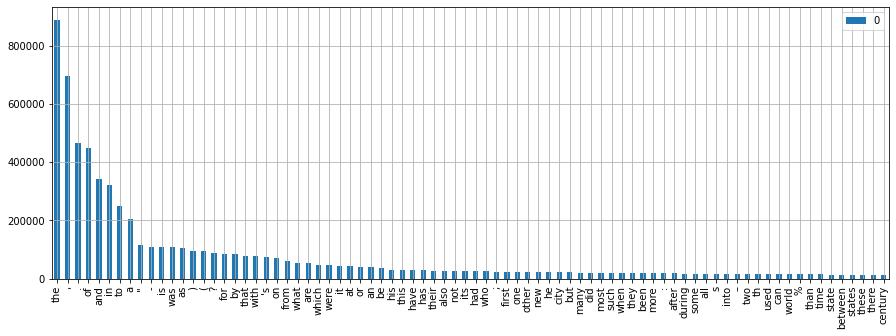

In [ ]:
def plot_counter(c):
  d = dict(c)
  s = pd.DataFrame.from_dict(d, orient='index')
  s.plot(kind='bar',grid=True, figsize=(15,5))

plot_counter(vocab.freqs.most_common(80))

*We* see, that the frequency of words is approximately inversely proportional to its rank - frequency of n-th most common word is proportional to $\frac{1}{n}$.  



**QUESTION #2**

---


**What is the name for this phenomena in linguistics?**

Answer: Zipf's Law

---

## Visualizing the word embeddings

In [ ]:
vocab.vectors

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

Next, **lets visualize vectorized word representations** using the [embedding projector](https://projector.tensorflow.org/).

<img src="https://github.com/eisenjulian/nlp_estimator_tutorial/blob/master/embeddings.gif?raw=true" alt="Drawing" width="400"/>





Unfortunately, google colab does not support embedding projector in the python notebook directly. However we can easily apply this great tool on `.tsv` files (tab separated values), so we just need to dump our embeddings and their respective names into `.tsv`.

The embeddings need to be in format:
```
0.1\t0.2\t0.5\t0.9\n  
0.2\t0.1\t5.0\t0.2\n  
0.4\t0.1\t7.0\t0.8\n 
```
where `\t` is TAB symbol and `\n` is end-of-line symbol.

Their respective names then need to be placed into files in correct order:
```    
Wartortle\n   
Venusaur\n   
Charmeleon\n   
```

In [ ]:
def dump_for_embedding_projector(dump_fn, vocab, top_n = 500):
  if not os.path.isdir("visualisations"):
    os.mkdir("visualisations")
  names = dict(vocab.freqs.most_common(top_n)).keys()
  data = [(name,vocab.vectors[vocab.stoi[name]].tolist()) for name in names]
  
  with open(f"visualisations/{dump_fn}_vectors.tsv","w") as f_vecs:
    with open(f"visualisations/{dump_fn}_names.tsv","w") as f_names:
      f_vec_writer = csv.writer(f_vecs, delimiter='\t')
      f_name_writer = csv.writer(f_names, delimiter='\t')
      for name, vector in data:
        f_name_writer.writerow([name])
        f_vec_writer.writerow(vector)
  
  
  

In [ ]:
dump_for_embedding_projector("input_embeddings",vocab)

Folder visualisations should now contain two files:
```
input_embeddings_names.tsv  input_embeddings_vectors.tsv
```

In [ ]:
# run this to make sure files have been generated.
!ls ./visualisations

input_embeddings_names.tsv  input_embeddings_vectors.tsv


**If these `.tsv` files have been generated**, proceed to https://projector.tensorflow.org/ , on the webpage click on "load" (left-upper corner) and the modal window will appear:

Click "Choose file" under "Step 1: Load a TSV file of vectors.", and select `input_embeddings_vectors.tsv` from PC. Wait until PCA is computed.  

Then, analogously, click "Choose file" under "
Step 2 (optional): Load a TSV file of metadata.", and select `input_embeddings_names.tsv` from your PC.

Now you can inspect your embedding under various dimension-reduction techniques (PCA, T-SNE, UMAP), that project them down into 3D (or 2D) space.

**QUESTION #3**

---


**Which three token representations are the closest to the token representations of "study" according to cosine distance?**

Answer: research, science, university

---

##Preprocessing errors
In the real world, no data preprocessing is perfect. When preprocessing our data, via method `get_example_list` of class `SquadDataset`, notice that code checks for errors – by comparing the reference answer extracted via character span annotation from dataset and preprocessed reference answer obtained by our token-span answer annotation. These errors (for validation data) are then written into `data/squad/errors_dev-v1.1.json.csv`.
Take a look at **two rightmost columns** containing token-span answers and character-span answers by looking into this `.csv` file.

**QUESTION #4**

---


**When comparing character-span annotated answers with token-span annotated answers, what is the most common source of an error?**


Answer: There is no common source of an error. If it would, it would be easy to fix and it would be fixed already :).

---

# Simple baseline model
Now we can proceed further towards building a simple model. The scheme of our model will look like this:


![Model](https://www.fit.vutbr.cz/~ifajcik/pubdata/bissit19/QA2.png)

**QUESTION #5**

---


**Recall the Query, Key, Value concept from General Attention explained in the lecture. What is the Query, Key and Value in the proposed document-to-question attention?**


Answer: One possible interpretation is to have $[q_s, q_e]$  represent the **query**, RNN outputs from document representation being a **key** and since we use our unnormalized attention scores for prediction, we can assume the **values** are represented by an identity matrix.

---

## Model code
In the following code, we will create a class inheriting from `torch.nn.Module`. Inheriting from this class will allow us to treat Baseline as an object containing parameters to optimize. As we will see later, PyTorch will automatically build computational graph for us and compute gradients for parameters used in the `forward` method.

**CHALLENGE**

---


**Try implementing steps 1 to 7 of proposed model framework**

---
Hints:
* PyTorch documentation: https://pytorch.org/docs/stable/index.html
* When doing matrix multiplication on batches, note keep an eye on batch matrix multiplication operation (abbreviation `bmm`).
* You may need to add or remove dimensions of a tensor (e.g. make Tensor of shape `[3, 16, 1]` from tensor of shape `[3, 16]`), look for `squeeze` and `unsqueeze` operations for this.

In [ ]:
class Baseline(torch.nn.Module):
    # We would like to define all the submodules of our model in initializer
    def __init__(self, config, vocab):
        super().__init__()
        # Embedder - module that constructs token embeddings from token indices
        self.embedder = Embedder(vocab, config)
        # Encoder - which encodes our word representations
        self.encoder = torch.nn.LSTM(
            config["RNN_input_dim"],
            config["RNN_nhidden"],
            config["RNN_layers"],
            dropout=float(config['dropout_rate']),
            batch_first=True,
            bidirectional=True)
        # linear projections, which project max-pooled question representation
        # into answer_start/ answer_end representing space
        self.lin_S = nn.Linear(config["RNN_nhidden"] * 2, config["RNN_nhidden"] * 2)
        self.lin_E = nn.Linear(config["RNN_nhidden"] * 2, config["RNN_nhidden"] * 2)
        
        # dropout - regularization
        self.dropout = nn.Dropout(p=config["dropout_rate"])

    def forward(self, batch,return_max=False):      
        # abbreviations and symbols:
        # batch_size - size of a mini-batch
        # d - embedding dimension
        # q_len - the length of the longest query in mini-batch
        # d_len - the length of the longest document in mini-batch
        # RNN_out - the output dimension of RNN
      
        # 1. Transform token indices to token embeddings
        # dimensions of query token indices: batch_size x q_len
        # dimensions of document token indices: batch_size x d_len
        # dimensions of query/document token embeddings:
        # batch_size x q_len x d / batch_size x d_len x d
        q_emb, d_emb = self.embedder(batch.question), self.embedder(batch.document)
        
        # 2. Call the encoder, pass question / document representation to it
        # batch_size x q_len x RNN_out / batch_size x d_len x RNN_out
        # do not forget to apply dropout!
        q_enc, d_enc = self.dropout(self.encoder(q_emb)[0]), self.dropout(self.encoder(d_emb)[0])
        
        # 3. Pick the maximum over time (dimension q_len) out of encoded question representations q_enc
        # batch_size x RNN_out
        q, argmax_q = q_enc.max(dim=-2)
        
        # 4. Project the max-pooled representation in start/end seeking space
        # do not forget to apply dropout!
        # both of shape batch_size x RNN_out
        q_s, q_e = self.dropout(self.lin_S(q)), self.dropout(self.lin_E(q))
        
        # 5. Change the shape of q_s, q_e to be:
        # batch_size x RNN_out x 1
        q_s.unsqueeze_(-1), q_e.unsqueeze_(-1)
        
        # 6. Attention 
        # do the batch-wise matrix multiplication between:
        # - q_s and encoded document contents d_enc obtaining unnormalized log probabilities of 
        # answer start
        # - q_e and encoded document contents d_enc obtaining unnormalized log probabilities of
        # answer end
        # both of shape batch_size x d_len x 1
        s, e = torch.bmm(d_enc, q_s), torch.bmm(d_enc, q_e)
        
        # 7. Reshape start / end representations to be batch_size x d_len
        # and return the unnormalized log probabilities
        # !Note that softmax is applied to these inside the CrossEntropyLoss error function.
        s.squeeze_(-1), e.squeeze_(-1)
        
        
        if return_max:
          return s, e, argmax_q
        return s, e

## Token indices to token embeddings
Next, we would like to implement submodule of our model, which returns embeddings of each input token. We can simply implement it like following:

In [ ]:
class Embedder(torch.nn.Module):
    def __init__(self, vocab, config):
        super().__init__()
        # Whether to scale gradient for embeddings by its frequency
        # (talk to me to explain this further)
        self.scale_grad = config['scale_emb_grad_by_freq']
        
        self.init_vocab(vocab, config['optimize_embeddings'])
        print(f"Optimize embeddings = {config['optimize_embeddings']}")
        print(f"Scale grad by freq: {self.scale_grad}")
        print(f"Vocabulary size = {len(vocab.vectors)}")

    def init_vocab(self, vocab, optimize_embeddings=False, device=None):
        self.embedding_dim = vocab.vectors.shape[1]
        # Create an torch.nn.Embedding abstraction
        self.embeddings = torch.nn.Embedding(len(vocab), self.embedding_dim, scale_grad_by_freq=self.scale_grad)
        
        # Copy over the pre-trained GloVe embeddings
        self.embeddings.weight.data.copy_(vocab.vectors)
        self.embeddings.weight.requires_grad = optimize_embeddings
        
        # Save also vocab, so we can access it later when loading the model if needed
        self.vocab = vocab
        
        # map to gpu
        if device is not None:
            self.embeddings = self.embeddings.to(device)

    def forward(self, input):
        return self.embeddings(input)

## Decoding the predictions
When having the output start/end output probabilities, we would like to find token-level indices of start/end of answer span with highest joint probability. Formally:  
$$a^*_{start},a^*_{end} = \argmax{a_{start},a_{end}}P_{\theta}(a_{start},a_{end}|Q,D)$$





since $a>b => log(a)>log(b)$, we can do this in the log domain as well:
$$a^*_{start},a^*_{end} = \argmax{a_{start},a_{end}}log P_{\theta}(a_{start},a_{end}|Q,D)$$

To use argmax only once, we can use a simple trick using modular arithmetics:  
![findmax](https://www.fit.vutbr.cz/~ifajcik/pubdata/bissit19/findmax.png)  
  
The implementation follows:

In [ ]:
def decode(span_start_logits: torch.Tensor, span_end_logits: torch.Tensor) -> \
        Tuple[torch.Tensor,Tuple[torch.Tensor, torch.Tensor]]:
    """
    This method has been borrowed from AllenNLP
    :param span_start_logits: unnormalized start log probabilities
    :param span_end_logits: unnormalized end log probabilities
    :return:
    """
    # We call the inputs "logits" - they could either be unnormalized logits or normalized log
    # probabilities.  A log_softmax operation is a constant shifting of the entire logit
    # vector, so taking an argmax over either one gives the same result.
    if span_start_logits.dim() != 2 or span_end_logits.dim() != 2:
        raise ValueError("Input shapes must be (batch_size, document_length)")
    batch_size, passage_length = span_start_logits.size()
    device = span_start_logits.device
   
  
    
    # span_start_logits.unsqueeze(2) has shape:
    # (batch_size, passage_length, 1)
    
    # span_end_logits.unsqueeze(1) has shape:
    # (batch_size, 1, passage_length)
    
    # Addition in log-domain = multiplication in real domain
    # This will create a matrix containing addition of each span_start_logit with span_end_logit
    # (batch_size, passage_length, passage_length)
    span_log_probs = span_start_logits.unsqueeze(2) + span_end_logits.unsqueeze(1)
    
    # Only the upper triangle of the span matrix is valid; the lower triangle has entries where
    # the span ends before it starts. We will mask these values out
    span_log_mask = torch.triu(torch.ones((passage_length, passage_length),
                                          device=device)).log().unsqueeze(0)
    # The mask will look like this
    #0000000
    #X000000
    #XX00000
    #XXX0000
    #XXXX000
    #XXXXX00
    #XXXXXX0
    # where X are -infinity
    valid_span_log_probs = span_log_probs + span_log_mask # see image above, part 1.
        
    
    # Here we take the span matrix and flatten it, then find the best span using argmax.  We
    # can recover the start and end indices from this flattened list using simple modular
    # arithmetic.
    # (batch_size, passage_length * passage_length)
    # valid_span_log_probs is a vector [s_00,s_01,...,s_0n,s10,s11,...,s1n, ... , sn0,sn1,..., snn] of span scores
    # e.g. s_01 is a score of answer span from token 0 to token 1
    valid_span_log_probs = valid_span_log_probs.view(batch_size, -1) # see image above, part 2.
    
    # Turn all the log-probabilities into probabilities
    valid_span_probs = F.softmax(valid_span_log_probs, dim=-1)

    best_span_probs, best_spans = valid_span_probs.max(-1) # see image above, part 3.
    # best_span_probs of shape batch_size now contains all probabilities for each best span in the batch
    # best_spans of shape batch_size now contains argmaxes of each answer from unrolled sequence valid_span_log_probs
    
    span_start_indices = best_spans // passage_length
    span_end_indices = best_spans % passage_length

    return best_span_probs, (span_start_indices, span_end_indices)

**QUESTION #6**

---


**Why does the `span_log_mask` variable in the `decode` function only contains values `0` and `-infinity`? What do these values represent?**

Answer: Because $log(1)=0$ and $log(0)=-infinity$. These values represent the mask of lower triangular matrix, which contains scores of positions where $a_{end}<a_{start}$.

### From decoded token-span back to decoded character-span
Having a predictions, we would like to indentify the correct spans in original text. It turns out, we cannot really find how the tokenized text fits back into our input! Assume we have tokenized the sentence:  
`"It happened, in the 1980s!"` as  
`It|happened|,|in|the|1980|s|!`   
After tokenization, we do not know where whitespace was, we do knot know what did the original sentence looked like. Has it been   
`"It happened , in the 1980 s!"`  
`"It happened,in the 1980s!"`  
`"It happened, in the 1980 s !"`  
?  


Luckily, recall that we have saved all token positions in advance! The positions of all tokens of  `i-th` document in the batch are saved in `batch.document_token_positions[i]`. For a predictions (candidates in following snippet), we can get the character answer spans as follows:

In [ ]:
def get_spans(batch, candidates):
  r = []
  for i in range(len(batch.raw_document_context)):
      candidate_start = candidates[0][i]
      candidates_end = candidates[1][i]
      
      # In initial state of learning, we can predict the start/end in the padding area
      # since we do not do the masking
      # We will fix that here.
      if candidate_start > len(batch.document_token_positions[i]) - 1:
          candidate_start = len(batch.document_token_positions[i]) - 1
      if candidates_end > len(batch.document_token_positions[i]) - 1:
          candidates_end = len(batch.document_token_positions[i]) - 1
      
      # If everything is OK, append (character_start,character_end) of answer span to r
      r.append(batch.raw_document_context[i][batch.document_token_positions[i][candidate_start][0]:
                                             batch.document_token_positions[i][candidates_end][-1]])
  return r

Next, we would like to defined training of 1 epoch. Having a model, lossfunction, optimizer and an iterator over data, we can compute the forward pass, calculate the gradients, clip their values if needed and adjust the parameters.

In [ ]:
def train_epoch(model: torch.nn.Module, lossfunction: _Loss, optimizer: torch.optim.Optimizer,
              train_iter: Iterator,gradient_clipping_norm = 5.) -> float:
  model.train()
  train_loss = 0
  # set gradients for all parameters to 0
  optimizer.zero_grad()
  for i, batch in enumerate(train_iter):
      # get the unnormalized log probabilities
      logprobs_S, logprobs_E = model(batch)
      
      # compute the (cross-entropy) loss for start and end separately
      loss_s = lossfunction(logprobs_S, batch.a_start)
      loss_e = lossfunction(logprobs_E, batch.a_end)
      loss = loss_s + loss_e
      
      loss.backward() # compute gradients
      torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), gradient_clipping_norm) # clip the gradients
      optimizer.step() # add portion of negative gradients to model parameters
      optimizer.zero_grad() # set gradients for all parameters to 0

      train_loss += loss.item() # .item() returns integer value from 0-dimensional torch tensor (scalar).

      if i % 300 == 0 and i > 0:
          print(f"Training loss: {train_loss / i + 1}")
  return train_loss / len(train_iter.data())


**QUESTION #7**

---


**Notice the gradient clipping via utility function `torch.nn.utils.clip_grad_norm_`. What is gradient clipping and what is it good for?**


Answer: To prevent exploding gradient problem, which is a common thing when optimizing model that contains recurrent neural network.

---

## Validation
To find, when to do the early stopping, how to optimize parameters and to have at least rough idea how the model works, we might need to run it on the data it have not seen during training. This is what the model validation is about. In the following snippet, we will calculate loss, exact match (EM) and F1 on validation data.


**Exact match (EM)** is a metric used in span-based question answering that measures the proportion of exactly matched answers.
$$ EM = \frac{\text{# of correctly answered questions}}{\text{# of all questions}} $$

**F1**  measures the average overlap between the prediction and ground truth  answer. Prediction and ground truth are treated as bags of tokens and their F1 is computed. Usually a maximum F1 over all of the ground truth answers for a given question is taken, and the result is an average over all of the questions. Assume the following example:

* Ground truth answer =$\{\text{cat named kitty}\} $
* Predicted answer =$\{\text{cat named}\} $
* $precision = \frac{\text{# of same tokens}}{\text{length of prediction}} = \frac{2}{2} $
* $recall = \frac{\text{# of same tokens}}{\text{length of ground truth}} = \frac{2}{3} $
* $ F1 = 2* \frac{precision * recall}{precision + recall} = 2* \frac{\frac{2}{2} * \frac{2}{3}}{\frac{2}{2} + \frac{2}{3}} = 0.8$

In [ ]:
@torch.no_grad() # do not create computational graph in this method, this saves memory
def validate(model: torch.nn.Module, lossfunction: _Loss, iter: Iterator,log_results=False) -> \
      Tuple[float, float, float]:
  # turn on evaluation mode (disable dropout etc.)
  model.eval()

  # initialize variables
  results = dict()
  ids = []
  lossvalues = []
  spans = []
  gt_spans = []
  span_probs = []
  
  # iterate over validation set
  for i, batch in enumerate(iter):
      ids += batch.id
      
      # get predictions
      logprobs_S, logprobs_E = model(batch)
      # compute loss
      loss_s = lossfunction(logprobs_S, batch.a_start)
      loss_e = lossfunction(logprobs_E, batch.a_end)
      loss = loss_s + loss_e
      
      # save loss values into list, we compute loss for each answer position
      # but later we will pick only the best prediction
      lossvalues += loss.tolist()
      
      # decode from log probabilities to predictions
      best_span_probs, candidates = decode(logprobs_S, logprobs_E)
      span_probs += best_span_probs.tolist()
      spans += get_spans(batch, candidates)
      gt_spans += batch.gt_answer

  # compute the final loss and results
  # we need to filter through multiple possible choices and pick the best one
  lossdict = defaultdict(lambda: math.inf)
  probs = defaultdict(lambda: 0)
  for id, value, span, span_prob in zip(ids, lossvalues, spans, span_probs):
      # record only lowest loss
      if lossdict[id] > value:
          lossdict[id] = value
      # record predicted result
      results[id] = span
      # record probability of predicted result
      probs[id] = span_prob
  
  # results logging 
  if log_results:
      write_results(results, probs)
  
  # compute loss from best answer predictions
  loss = sum(lossdict.values()) / len(lossdict)
  
  # write out predictions for evaluation script
  prediction_file = f"data/squad/dev_results_{socket.gethostname()}.json"
  with open(prediction_file, "w") as f:
      json.dump(results, f)

  # initialize arguments of evaluation script
  dataset_file = "data/squad/dev-v1.1.json"
  expected_version = '1.1'
  with open(dataset_file) as dataset_file:
      dataset_json = json.load(dataset_file)
      if (dataset_json['version'] != expected_version):
          print('Evaluation expects v-' + expected_version +
                       ', but got dataset with v-' + dataset_json['version'],
                       file=sys.stderr)
      dataset = dataset_json['data']
  with open(prediction_file) as prediction_file:
      predictions = json.load(prediction_file)
  # run the evaluation script
  result = evaluate(dataset, predictions)
  

  return loss, result["exact_match"], result["f1"]

## Model fitting pipeline
Finally, we would like to run training epochs, until we see not improvement in validation loss. This is the time when to do the early stopping.

In [ ]:
def fit(config, device):
  # print configuration
  print(json.dumps(config, indent=4, sort_keys=True))

  # prepare torchtext fields (different in case of character embeddings)
  if config["char_embeddings"]:
      fields = SquadDataset.prepare_fields_char()
  else:
      fields = SquadDataset.prepare_fields()
  
  # create train/validation datasets
  train, val = SquadDataset.splits(fields)
  fields = dict(fields)
  
  # we use the same field for question and document
  # we can build vocabulary of words it represents by calling build_vocab [this takes a while]
  # for each used word, we can pick the glove embedding and create an embedding matrix with index to embedding mapping
  fields["question"].build_vocab(train, val, vectors=GloVe(name='6B', dim=config["embedding_size"]))
  
  # similarly, we can build character vocabulary, if needed
  if not type(fields["question_char"]) == torchtext.data.field.RawField:
      fields["question_char"].build_vocab(train, val, max_size=config["char_maxsize_vocab"])

  # shuffle the examples to get the best distribution estimate
  train_iter = BucketIterator(train, sort_key=lambda x: -(len(x.question) + len(x.document)),
                              shuffle=True, sort=False, sort_within_batch=True,
                              batch_size=config["train_batch_size"], train=True,
                              repeat=False,
                              device=device)
  
  # sort validation examples for faster validation
  val_iter = BucketIterator(val, sort_key=lambda x: -(len(x.question) + len(x.document)), sort=True,
                            batch_size=config["validation_batch_size"],
                            repeat=False,
                            device=device)
  # create model
  model = Baseline(config, fields["question"].vocab).to(device)
  
  # create optimizer
  optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                   lr=config["learning_rate"])

  start_time = time.time()
  best_model = None
  try:
      best_val_loss = math.inf
      best_val_f1 = 0
      best_em = 0
      no_improvement = 0
      for it in range(config["max_iterations"]):
          print(f"Iteration {it}")
          # run training epoch
          train_epoch(model, CrossEntropyLoss(), optimizer, train_iter)
          
          # validate model
          validation_loss, em, f1 = validate(model, CrossEntropyLoss(reduction='none'), val_iter)     
          print(f"Validation loss/F1/EM: {validation_loss:.2f}, {f1:.2f}, {em:.2f}")
          
          # increment the patience counter
          no_improvement+=1
          
          # Update the best statistics if needed
          if validation_loss < best_val_loss: 
              best_val_loss = validation_loss
              no_improvement = 0
          if f1 > best_val_f1: 
            best_val_f1 = f1
          if em > best_em: 
            best_em = em
            model = model.to(torch.device("cpu"))
            best_model = copy.deepcopy(model)
            model = model.to(torch.device("cuda"))
          print(f"BEST L/F1/EM = {best_val_loss:.2f}/{best_val_f1:.2f}/{best_em:.2f}")
          
          # Early stopping
          # if the validation loss did not improved for several iterations
          # the training is finished
          if no_improvement>=config["patience"]:
            break
       

  except KeyboardInterrupt:
      print('-' * 120)
      print('Exit from training early.')
  finally:
      print(f'Finished after {(time.time() - start_time) / 60} minutes.')
      return best_model,best_val_loss, best_val_f1, best_em

**QUESTION #8**

---


**Assume we would like our model to get the best performance on the \*training\* data. When should we do the early stopping?**


Answer: Never. We let the model converge on the training data.

---

## Running model training
We are done with model implementation. Lets guess our hyperparameter configuration and run the training for the first time. Is the loss decreasing? If you have enough time, you can try to change the hyperparameters to obtain better performance. In practice, we often optimize hyperparameters with optimizers working over real-valued, discrete, and conditional dimensions, such as *Tree of Parzen Estimators* implemented in [HyperOpt](http://hyperopt.github.io/hyperopt/) package. 

**Note that you may stop training whenever you want by hitting stop button of the notebook's cell.**

In [ ]:
baseline_config = {"modelname": "baseline",
                   "train_batch_size": 80,
                   "validation_batch_size": 128,
                   "embedding_size": 100,
                   "optimize_embeddings": False,
                   "scale_emb_grad_by_freq": False,
                   "RNN_input_dim": 100,
                   "dropout_rate": 0.2,
                   "RNN_nhidden": 100,
                   "learning_rate": 5e-3,
                   "RNN_layers": 1,
                   "max_iterations": 100,
                   "optimizer": "adam",
                   "patience":2,
                   "char_embeddings": False}

model, validation_loss, f1, em = fit(baseline_config, device)

{
    "RNN_input_dim": 100,
    "RNN_layers": 1,
    "RNN_nhidden": 100,
    "char_embeddings": false,
    "dropout_rate": 0.2,
    "embedding_size": 100,
    "learning_rate": 0.005,
    "max_iterations": 100,
    "modelname": "baseline",
    "optimize_embeddings": false,
    "optimizer": "adam",
    "patience": 2,
    "scale_emb_grad_by_freq": false,
    "train_batch_size": 80,
    "validation_batch_size": 128
}
Dataset data/squad/train-v1.1.json_preprocessed.json loaded in 28.81 s
# problems: 122
Problems affect 0.00004 % of dataset.
Dataset data/squad/dev-v1.1.json_preprocessed.json created in 30.97866415977478s
Dataset data/squad/dev-v1.1.json_preprocessed.json loaded in 6.53 s
Optimize embeddings = False
Scale grad by freq: False
Vocabulary size = 88973
Iteration 0
Training loss: 8.250473054250081
Training loss: 7.814940925439199
Training loss: 7.573482757144504
Validation loss/F1/EM: 5.46, 31.19, 21.02
BEST L/F1/EM = 5.46/31.19/21.02
Iteration 1
Training loss: 6.758845671017965
T

If you managed to train the model, lets save it. So we can load it if, e.g. our notebook's interpreter crashes.

In [ ]:
if not os.path.isdir("saved"):
  os.mkdir("saved")
torch.save(model, f"saved/checkpoint"
                  f"_{str(model.__class__)}"
                  f"_EM_{em:.2f}_F1_{f1:.2f}_L_{validation_loss:.2f}"
                  f"_{get_timestamp()}_{socket.gethostname()}.pt")

#Introspecting the baseline

Failed to train the model? Don't worry! You can get the pretrained checkpoint like this:

In [ ]:
# Uncomment to download and load pre-trained model
# !wget -P "saved/" -nc "https://www.fit.vutbr.cz/~ifajcik/pubdata/bissit19/checkpoint_Baseline_EM_28.33_F1_39.01_L_4.78.pt"
# model = torch.load("saved/checkpoint_Baseline_EM_28.33_F1_39.01_L_4.78.pt")


**In case you trained your model, but you managed to lose it somehow. rememember you can still load it from `saved` directory using `torch.load`.**

Now when we trained the model, we need to switch it into evaluation mode by calling `.eval()`,  so its components behave like they should in test time.

In [ ]:
model = model.to(torch.device("cuda"))
model = model.eval()

**QUESTION #9**

---


**What component of neural network behaves differently in test time and what is the difference between its function in train time and test time?**


Answer: Dropout,  in training time it behaves like a regularizer, setting random count of it's inputs to 0.Its randomness is controlled by its parameter $p$ denoting the probability of value being set to zero. In test time, the expected output from layer with droput is $p\mathop{\mathbb{E}}[Wx + b]$. We mitigate this effect by scaling weights by $\frac{1}{p}$ so the expected output is $\mathop{\mathbb{E}}[Wx + b]$.

---

## Analyzing the parameters
Next, lets look at parameters, our model contains.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
print(f"Models has {count_parameters(model)} parameters")

Models has 242000 parameters


In [ ]:
def report_parameters(model):
    num_pars = {name: p.numel() for name, p in model.named_parameters() if p.requires_grad}
    num_sizes = {name: p.shape for name, p in model.named_parameters() if p.requires_grad}
    return num_pars, num_sizes
  
param_sizes, param_shapes = report_parameters(model)
param_sizes = "\n'".join(str(param_sizes).split(", '"))
param_shapes = "\n'".join(str(param_shapes).split(", '"))
print(f"Model structure:\n{param_sizes}\n{param_shapes}\n")

Model structure:
{'encoder.weight_ih_l0': 40000
'encoder.weight_hh_l0': 40000
'encoder.bias_ih_l0': 400
'encoder.bias_hh_l0': 400
'encoder.weight_ih_l0_reverse': 40000
'encoder.weight_hh_l0_reverse': 40000
'encoder.bias_ih_l0_reverse': 400
'encoder.bias_hh_l0_reverse': 400
'lin_S.weight': 40000
'lin_S.bias': 200
'lin_E.weight': 40000
'lin_E.bias': 200}
{'encoder.weight_ih_l0': torch.Size([400, 100])
'encoder.weight_hh_l0': torch.Size([400, 100])
'encoder.bias_ih_l0': torch.Size([400])
'encoder.bias_hh_l0': torch.Size([400])
'encoder.weight_ih_l0_reverse': torch.Size([400, 100])
'encoder.weight_hh_l0_reverse': torch.Size([400, 100])
'encoder.bias_ih_l0_reverse': torch.Size([400])
'encoder.bias_hh_l0_reverse': torch.Size([400])
'lin_S.weight': torch.Size([200, 200])
'lin_S.bias': torch.Size([200])
'lin_E.weight': torch.Size([200, 200])
'lin_E.bias': torch.Size([200])}



## Introspecting the predictions on validation data
Lets run the validation one more time, but this time, we will log all the predictions into a `.csv` file. This way, we sort out the most confident predictions, least confident predictions, correct/incorrect predictions, or just take a look at errors, model did in its predictions.

In [ ]:
def write_results(results, probs, val_file="data/squad/dev-v1.1.json"):
  if not os.path.isdir("results"):
    os.mkdir("results")
  f = open(f"results/result_{get_timestamp()}_{socket.gethostname()}.csv", mode="w")
  csvw = csv.writer(f, delimiter=',')
  HEADER = ["Correct", "Ground Truth(s)", "Prediction", "Confidence", "Question", "Context", "Topic", "ID"]
  csvw.writerow(HEADER)
  with open(val_file) as fd:
      data_json = json.load(fd)
      for data_topic in data_json["data"]:
          for paragraph in data_topic["paragraphs"]:
              for question_and_answers in paragraph['qas']:
                  prediction = results[question_and_answers["id"]]
                  confidence = str(f"{probs[question_and_answers['id']]:.2f}")
                  answers = "|".join(map(lambda x: x['text'], question_and_answers['answers']))
                  correct = int(results[question_and_answers["id"]].lower() in map(lambda x: x['text'].lower(),
                                                                                   question_and_answers[
                                                                                       'answers']))
                  ex = [correct,
                        answers,
                        prediction,
                        confidence,
                        question_and_answers['question'],
                        paragraph["context"],
                        data_topic["title"],
                        question_and_answers["id"]]
                  csvw.writerow(ex)
  f.close()

Running the following snippet will create `results_<time>_<pcname>.csv` file inside `resuls` directory. Download the `.csv` and open it in your favorite `.csv` browser.

In [ ]:
fields = SquadDataset.prepare_fields()
val = SquadDataset(VALIDATION, fields, cachedir="data/squad")

val_iter = BucketIterator(val, sort_key=lambda x: -(len(x.question) + len(x.document)), sort=True,
                            batch_size=baseline_config["validation_batch_size"],
                            repeat=False,
                            device=device)


Dataset data/squad/dev-v1.1.json_preprocessed.json loaded in 11.98 s


In [ ]:
fields=dict(fields)
fields["question"].vocab = model.embedder.vocab
validation_loss, em, f1 = validate(model, CrossEntropyLoss(reduction='none'), val_iter, log_results=True) 

## Playing with our model
At last, we can try to give model our own questions and try looking at how it behaves!

In [ ]:

document = "In 1952, when the release of the FCC's Sixth Report and Order announced the end of its freeze" \
          " on new station license applications, among the issues the Commission was slated to address was" \
          " whether to approve the UPT-ABC merger. One FCC Commissioner saw the possibility of ABC, funded" \
          " by UPT, becoming a viable and competitive third television network. On February 9, 1953, the FCC" \
          " approved UPT's purchase of ABC in exchange for $25 million in shares. The merged company, renamed" \
          " American Broadcasting-Paramount Theatres, Inc. and headquartered in the Paramount Building at 1501 " \
          "Broadway in Manhattan, owned six AM and several FM radio stations, five television stations and 644 " \
          "cinemas in 300 U.S. cities. To comply with FCC ownership restrictions in effect at the time that" \
          " barred common ownership of two television stations in the same market, UPT sold its Chicago " \
          "television station, WBKB-TV, to CBS (which subsequently changed the station's call letters to WBBM-TV) " \
          "for $6 million, while it kept ABC's existing Chicago station, WENR-TV. The merged company acquired the WBKB " \
          "call letters for channel 7, which would eventually become WLS-TV. Goldenson began to sell some of the older " \
          "theaters to help finance the new television network."

question = "Where was American Broadcasting-Paramount Theatres, Inc headquartered after the merger?"


In [ ]:
# make sure the current vocab is model's vocab
vocab = model.embedder.vocab

# tokenization
document_tokens, tokenized_document_list = tokenize(document)
tokenized_question_list = tokenize(question)[1]

# keep positions of each token in document, we will need this later, when decoding model outputs
document_token_positions = [[token.idx, token.idx + len(token.text)] for token in document_tokens]

# lowercasing and numericalization
numericalized_document = [vocab.stoi[s.lower()] for s in tokenized_document_list]
numericalized_question = [vocab.stoi[s.lower()] for s in tokenized_question_list]

# create very simple batch object
class simple_batch():
  def __init__(self,q,d,raw_d,d_pos):
    map_to_gpu_tensor = lambda x: torch.Tensor(x).long().to(torch.device("cuda")).unsqueeze(0)
    self.question=map_to_gpu_tensor(q)
    self.document=map_to_gpu_tensor(d)
    self.raw_document_context = [raw_d]
    self.document_token_positions = [d_pos]
batch = simple_batch(numericalized_question,numericalized_document,document,document_token_positions)

 # get predictions with arg_maxes
logprobs_S, logprobs_E, argmax_Q = model.forward(batch, return_max=True)

# decode from log probabilities to predictions
best_span_prob, candidate = decode(logprobs_S, logprobs_E)
confidence =  best_span_prob.item()
answer = get_spans(batch, candidate)[0]

print(f"The answer is: \"{answer}\".")
print(f"The model is confident with {confidence:.2f} probability.")

The answer is: "Manhattan".
The model is confident with 0.10 probability.


**Now lets try various questions and see how model responds!**

In [ ]:
question = "When was he imprisoned?"
document = "Fourier was born at Auxerre (now in the Yonne département of France), the son of a tailor. He was orphaned at the age of nine. Fourier was recommended to the Bishop of Auxerre and, through this introduction, he was educated by the Benedictine Order of the Convent of St. Mark. The commissions in the scientific corps of the army were reserved for those of good birth, and being thus ineligible, he accepted a military lectureship on mathematics. He took a prominent part in his own district in promoting the French Revolution, serving on the local Revolutionary Committee. He was imprisoned briefly during the Terror but, in 1795, was appointed to the École Normale and subsequently succeeded Joseph-Louis Lagrange at the École Polytechnique."

In [ ]:
document = "He said that she goes squeek, and others disagreed, saying that she does quack."
question = "What does the fox say?"

In [ ]:
document = "Gordon Matthew Thomas Sumner CBE (born 2 October 1951), known as Sting, is an English musician and actor. He was the principal songwriter, lead singer, and bassist for the new wave rock band the Police from 1977 to 1984, and launched a solo career in 1985. He has included elements of rock, jazz, reggae, classical, new-age and worldbeat in his music."
question = "Where he comes from?"

## Visualisations
Lets take a look at computational graph torch derived for gradient backpropagation. We may use method `make_dot` from `torchviz` library for that.

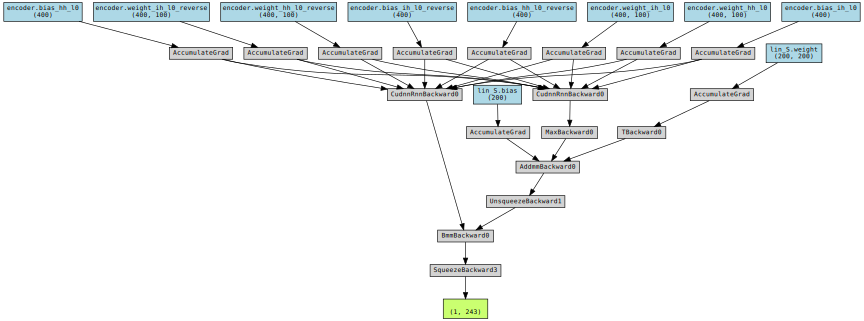

In [ ]:
make_dot(logprobs_S,dict(model.named_parameters()))

Next, we can look at probabilities model returned for stard and end of span.

Start probabilities:


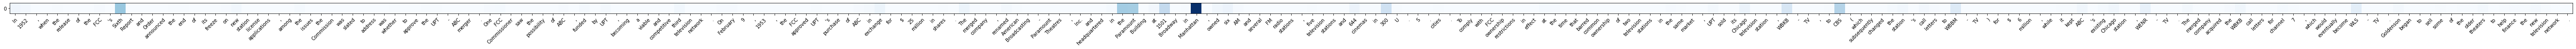

End probabilities:


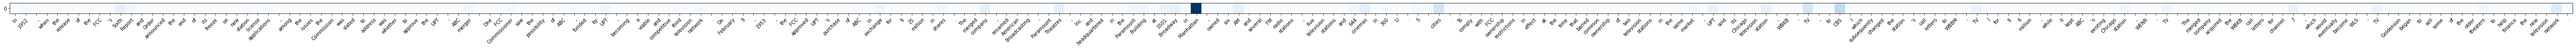

In [ ]:
def visualize_att(doc_attention,doc_text):
  """
  This part of code has been taken from bc thesis code of Alžbeta Štajerová
  """

  fig, ax = plt.subplots()
  fig.set_size_inches(len(doc_text), 0.4)
  ax.imshow(doc_attention.cpu().detach().numpy(), cmap='Blues')

  ax.set_xticks(np.arange(len(doc_text)))
  ax.set_yticks(np.arange(doc_attention.shape[0]))
  ax.set_xticklabels(doc_text)
  ax.set_yticklabels([idx for idx in range(doc_attention.shape[0])])

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  plt.show()

print("Start probabilities:")
visualize_att(F.softmax(logprobs_S,-1),tokenized_document_list)
print("End probabilities:")
visualize_att(F.softmax(logprobs_E,-1),tokenized_document_list)

At last, we can also take a look at from which positions of RNN output model took the maximums. However, as you can see for youself, it is not easy to interpret values of neural network.

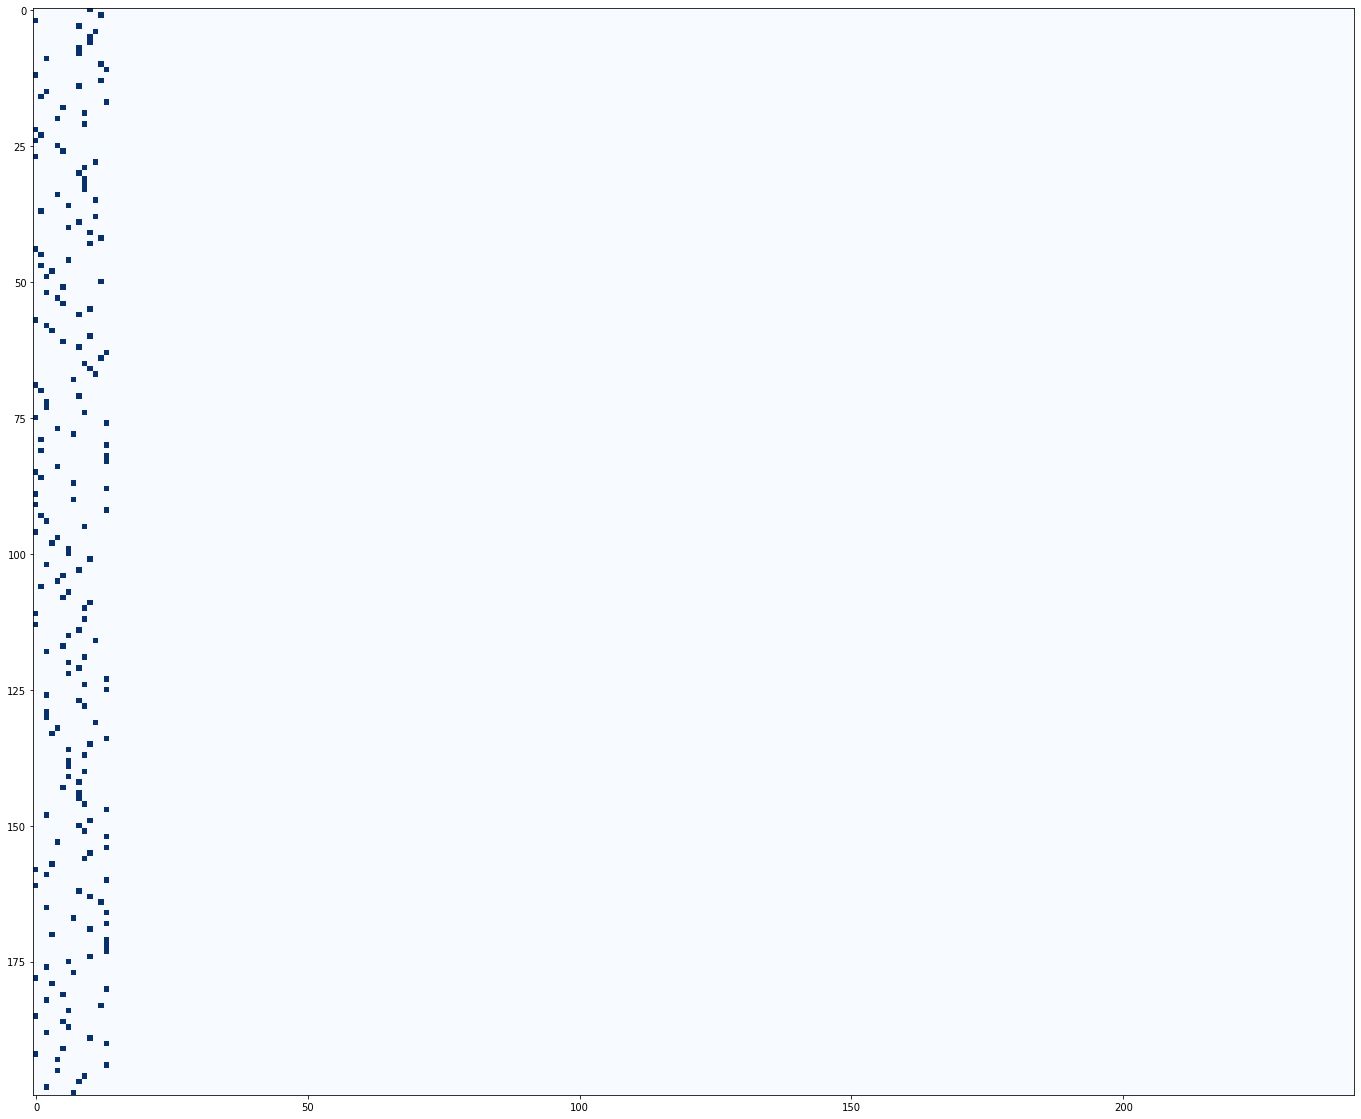

array([[10, 12,  0,  8, 11, 10, 10,  8,  8,  2, 12, 13,  0, 12,  8,  2,
         1, 13,  5,  9,  4,  9,  0,  1,  0,  4,  5,  0, 11,  9,  8,  9,
         9,  9,  4, 11,  6,  1, 11,  8,  6, 10, 12, 10,  0,  1,  6,  1,
         3,  2, 12,  5,  2,  4,  5, 10,  8,  0,  2,  3, 10,  5,  8, 13,
        12,  9, 10, 11,  7,  0,  1,  8,  2,  2,  9,  0, 13,  4,  7,  1,
        13,  1, 13, 13,  4,  0,  1,  7, 13,  0,  7,  0, 13,  1,  2,  9,
         0,  4,  3,  6,  6, 10,  2,  8,  5,  4,  1,  6,  5, 10,  9,  0,
         9,  0,  8,  6, 11,  5,  2,  9,  6,  8,  6, 13,  9, 13,  2,  8,
         9,  2,  2, 11,  4,  3, 13, 10,  6,  9,  6,  6,  9,  6,  8,  5,
         8,  8,  9, 13,  2, 10,  8,  9, 13,  4, 13, 10,  9,  3,  0,  2,
        13,  0,  8, 10, 12,  2, 13,  7, 13, 10,  3, 13, 13, 13, 10,  6,
         2,  7,  0,  3, 13,  5,  2, 12,  6,  0,  5,  6,  2, 10, 13,  5,
         0,  4, 13,  4,  9,  8,  2,  7]])

In [ ]:
# transform the indices of maximum into numpy array
max_mask = argmax_Q.cpu().detach().numpy()

# create an array of shape out_RNN x doc_len
m = np.zeros((max_mask.shape[-1],logprobs_S.shape[-1]))

# create 1-hot vectors
m[np.arange(max_mask.shape[-1]), max_mask] = 1

# plot the matrix
fig, ax = plt.subplots()
fig.set_size_inches(logprobs_S.shape[-1],20)
ax.imshow(m, cmap='Blues');
plt.show()

max_mask


**Go ahead and play with different questions!**

#[BONUS] Character-level word embeddings
Add character-level word embeddings to the GloVe word embeddings. The character level embeddings are commonly based on 1D convolution over the characters followed by max-pooling.  
To fuse word-level and character-level representations you can use addition, concatenation, or e.g. a highway network.   
Highway network paper: https://arxiv.org/pdf/1505.00387.pdf

The implementation of both is provided below.

In [ ]:
class CharEmbedder(torch.nn.Module):
    def __init__(self, config, vocab):
        super().__init__()
        self.embeddings = nn.Embedding(len(vocab), config["char_embedding_size"], padding_idx=1)
        self.embeddings.weight.data.uniform_(-0.001, 0.001)
        self.dropout = nn.Dropout(p=config["dropout_rate"])
        self.char_conv = nn.Conv2d(1,  # input channels
                                   config["char_channel_size"],  # output channels
                                   (config["char_embedding_size"], config["char_channel_width"])  # kernel size
                                   )

    def forward(self, input):
        """
            :param x: (batch, seq_len, word_len)
            :return: (batch, seq_len, char_channel_size)
        """
        batch_size = input.shape[0]
        word_len = input.shape[-1]
        # (batch, seq_len, word_len, char_dim)
        x = self.dropout(self.embeddings(input))
        char_dim = x.shape[-1]
        # (batch * seq_len, 1, char_dim, word_len)
        x = x.view(-1, char_dim, word_len).unsqueeze(1)
        # (batch * seq_len, char_channel_size, conv_len)
        x = self.char_conv(x).squeeze()
        # (batch * seq_len, char_channel_size)
        x = F.max_pool1d(x, x.shape[2]).squeeze()
        # (batch, seq_len, char_channel_size)
        x = x.view(batch_size, -1, x.shape[-1])
        return x

In [ ]:
class HighwayNetwork(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = config["highway_layers"]
        for i in range(self.layers):
            setattr(self, f'highway_linear{i}',
                    nn.Sequential(nn.Linear(config["highway_dim"] * 2, config["highway_dim"] * 2),
                                  nn.ReLU()))
            gate = nn.Linear(config["highway_dim"] * 2, config["highway_dim"] * 2)

            # We should bias the highway layer to just carry its input forward when training starts.
            # We do that by setting the bias on gate affine transformation to be positive, because
            # that means `g` will be biased to be high, so we will carry the input forward.
            # The bias on `B(x)` is the second half of the bias vector in each Linear layer.
            gate.bias.data.fill_(1)

            setattr(self, f'highway_gate{i}',
                    nn.Sequential(gate,
                                  nn.Sigmoid()))

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=-1)
        for i in range(self.layers):
            h = getattr(self, f'highway_linear{i}')(x)
            g = getattr(self, f'highway_gate{i}')(x)
            x = (1 - g) * h + g * x
        return x

#[BONUS++] Bi-Directional Attention Flow for Machine Comprehension
<img src="https://allenai.github.io/bi-att-flow/BiDAF.png" alt="Drawing" width="700"/>

If you feel confident with the contents of today's excersise, go ahead and try to implement Bidaf model.  
Bidaf paper link: https://arxiv.org/pdf/1611.01603.pdf

You can also find its implementation compatible with preprocessing we introduced today [at my GitHub](https://github.com/MFajcik/BidAF/blob/master/models/QA_bidaf_vanilla.py).

#A note about minor similifications in this notebook

- Preprocessing – there are various problems with tokenization of ending brackets, which could be improved to further reduce number of preprocessing errors.
- Masking – in this excersise, we do not really apply masking of attention and rnns. This means the output probabilities for a start and end distribution may change a little, when model receives input with different padding.
- Training loss – our training loss as an online average when the model is in .train() mode. This means dropouts are active. This means the loss we see is not correctly computed cross-entropy loss on our train data (but it is 'similar' to it).
- Model dimensions – our model has very small dimensions to speed up training and experiments with it.
- Absence of test data – SQuAD does not provide public test set, which could be used to obtain final model performance. The test set is hidden and is used only internally by the organizers after model submission.